# 019 - Sklearn DuckDB SQL Classification (Sklearn Visualizations)

This notebook mirrors the **DuckDB SQL preprocessing** used in the SvelteKit Batch ML classification flow,
but excludes YellowBrick so we can focus on native sklearn visualization APIs.

In [1]:
import duckdb
import os
import pandas as pd
from sklearn.model_selection import train_test_split

In [2]:
MINIO_HOST = "localhost"
MINIO_PORT = "9000"
MINIO_ENDPOINT = f"{MINIO_HOST}:{MINIO_PORT}"
MINIO_ACCESS_KEY = "minioadmin"
MINIO_SECRET_KEY = "minioadmin123"
PROJECT_NAME = "Transaction Fraud Detection"

In [3]:
DELTA_PATHS = {
    "Transaction Fraud Detection": "s3://lakehouse/delta/transaction_fraud_detection",
    "Estimated Time of Arrival": "s3://lakehouse/delta/estimated_time_of_arrival",
    "E-Commerce Customer Interactions": "s3://lakehouse/delta/e_commerce_customer_interactions",
}

delta_path = DELTA_PATHS.get(PROJECT_NAME)

In [4]:
# Disable AWS EC2 metadata service lookup (prevents 169.254.169.254 errors)
os.environ["AWS_EC2_METADATA_DISABLED"] = "true"

# Create connection (in-memory database)
conn = duckdb.connect()

# Install and load required extensions
conn.execute("INSTALL delta; LOAD delta;")
conn.execute("INSTALL httpfs; LOAD httpfs;")

# Create a secret for S3/MinIO credentials
conn.execute(f"""
    CREATE SECRET minio_secret (
        TYPE S3,
        KEY_ID '{MINIO_ACCESS_KEY}',
        SECRET '{MINIO_SECRET_KEY}',
        REGION 'us-east-1',
        ENDPOINT '{MINIO_ENDPOINT}',
        URL_STYLE 'path',
        USE_SSL false
    );
""")
print("DuckDB extensions loaded and S3 secret configured")

DuckDB extensions loaded and S3 secret configured


## Feature Definitions

Define features upfront for CatBoost's native categorical handling.

In [5]:
# Feature definitions for Transaction Fraud Detection
TFD_NUMERICAL_FEATURES = [
    "amount",
    "account_age_days",
    "cvv_provided",
    "billing_address_match",
]

TFD_CATEGORICAL_FEATURES = [
    "currency",
    "merchant_id",
    "payment_method",
    "product_category",
    "transaction_type",
    "browser",
    "os",
    "year",
    "month",
    "day",
    "hour",
    "minute",
    "second",
]

TFD_ALL_FEATURES = TFD_NUMERICAL_FEATURES + TFD_CATEGORICAL_FEATURES

# Categorical feature indices for CatBoost (position in feature list)
TFD_CAT_FEATURE_INDICES = list(range(
    len(TFD_NUMERICAL_FEATURES),
    len(TFD_ALL_FEATURES)
))

print(f"Numerical features: {len(TFD_NUMERICAL_FEATURES)}")
print(f"Categorical features: {len(TFD_CATEGORICAL_FEATURES)}")
print(f"Categorical indices: {TFD_CAT_FEATURE_INDICES}")

Numerical features: 4
Categorical features: 13
Categorical indices: [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]


## DuckDB SQL Preprocessing

All categorical features are label-encoded in SQL using `DENSE_RANK() - 1`.

In [6]:
def load_data_duckdb_sql(
    delta_path: str,
    sample_frac: float | None = None,
    max_rows: int | None = None,
) -> pd.DataFrame:
    """
    Load and preprocess data using pure DuckDB SQL.
    
    All categorical features are label-encoded using DENSE_RANK() - 1.
    This produces numeric data compatible with sklearn visualization APIs.
    
    Args:
        delta_path: Path to Delta Lake table
        sample_frac: Optional fraction of data to sample (0.0-1.0)
        max_rows: Optional maximum number of rows to load
    
    Returns:
        DataFrame with preprocessed features (all numeric) and target
    """
    # Single query: All features numeric, categoricals label-encoded
    query = f"""
    SELECT
        -- Numerical features (unchanged)
        amount,
        account_age_days,
        CAST(cvv_provided AS INTEGER) AS cvv_provided,
        CAST(billing_address_match AS INTEGER) AS billing_address_match,

        -- Categorical features: Label encoded with DENSE_RANK() - 1
        -- This produces 0-indexed integers compatible with sklearn tools
        DENSE_RANK() OVER (ORDER BY currency) - 1 AS currency,
        DENSE_RANK() OVER (ORDER BY merchant_id) - 1 AS merchant_id,
        DENSE_RANK() OVER (ORDER BY payment_method) - 1 AS payment_method,
        DENSE_RANK() OVER (ORDER BY product_category) - 1 AS product_category,
        DENSE_RANK() OVER (ORDER BY transaction_type) - 1 AS transaction_type,
        
        -- JSON extraction + Label encoded
        DENSE_RANK() OVER (ORDER BY json_extract_string(device_info, '$.browser')) - 1 AS browser,
        DENSE_RANK() OVER (ORDER BY json_extract_string(device_info, '$.os')) - 1 AS os,

        -- Timestamp components (already integers)
        CAST(date_part('year', CAST(timestamp AS TIMESTAMP)) AS INTEGER) AS year,
        CAST(date_part('month', CAST(timestamp AS TIMESTAMP)) AS INTEGER) AS month,
        CAST(date_part('day', CAST(timestamp AS TIMESTAMP)) AS INTEGER) AS day,
        CAST(date_part('hour', CAST(timestamp AS TIMESTAMP)) AS INTEGER) AS hour,
        CAST(date_part('minute', CAST(timestamp AS TIMESTAMP)) AS INTEGER) AS minute,
        CAST(date_part('second', CAST(timestamp AS TIMESTAMP)) AS INTEGER) AS second,

        -- Target
        is_fraud

    FROM delta_scan('{delta_path}')
    """
    
    print(f"Loading data with DuckDB SQL (all features numeric)...")

    # Add sampling clause
    if sample_frac is not None and 0 < sample_frac < 1:
        query += f" USING SAMPLE {sample_frac * 100}%"
        print(f"  Sampling: {sample_frac * 100}%")

    # Add limit clause
    if max_rows is not None:
        query += f" LIMIT {max_rows}"
        print(f"  Max rows: {max_rows}")

    df = conn.execute(query).df()
    print(f"  Loaded {len(df):,} rows with {len(df.columns)} columns")
    print(f"  All features numeric: {df.select_dtypes(include=['number']).shape[1]}/{len(df.columns)} columns")
    
    return df

In [7]:
df = load_data_duckdb_sql(delta_path, max_rows=10000)

Loading data with DuckDB SQL (all features numeric)...
  Max rows: 10000


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

  Loaded 10,000 rows with 18 columns
  All features numeric: 18/18 columns


In [8]:
def process_batch_data_duckdb(
    df: pd.DataFrame,
    test_size: float = 0.2,
    random_state: int = 42,
):
    """
    Process batch data for model training.
    
    Data is already all-numeric from load_data_duckdb_sql().
    
    Args:
        df: DataFrame from load_data_duckdb_sql() (all numeric)
        test_size: Fraction for test set
        random_state: Random seed
    
    Returns:
        X_train, X_test, y_train, y_test
    """
    # Split features and target
    y = df["is_fraud"]
    X = df.drop("is_fraud", axis=1)
    
    print(f"Features: {len(X.columns)} total ({len(TFD_NUMERICAL_FEATURES)} numeric, {len(TFD_CATEGORICAL_FEATURES)} label-encoded)")
    print(f"All features are numeric - compatible with sklearn tools")
    
    # Stratified train/test split (keeps class balance)
    print(f"Splitting data: {1-test_size:.0%} train, {test_size:.0%} test (stratified)...")
    X_train, X_test, y_train, y_test = train_test_split(
        X, y,
        test_size=test_size,
        stratify=y,
        random_state=random_state,
    )
    
    print(f"  Training set: {len(X_train):,} samples")
    print(f"  Test set: {len(X_test):,} samples")
    
    # Calculate class balance
    fraud_rate = y_train.sum() / len(y_train) * 100
    print(f"  Fraud rate in training set: {fraud_rate:.2f}%")
    
    return X_train, X_test, y_train, y_test

In [9]:
X_train, X_test, y_train, y_test = process_batch_data_duckdb(df)

Features: 17 total (4 numeric, 13 label-encoded)
All features are numeric - compatible with sklearn tools
Splitting data: 80% train, 20% test (stratified)...
  Training set: 8,000 samples
  Test set: 2,000 samples
  Fraud rate in training set: 1.12%


## Sklearn Visualization API (Classification)

This section mirrors the YellowBrick visualizer configuration pattern from notebook 010,
but uses sklearn Display classes and tuned kwargs for classification.

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.calibration import CalibrationDisplay
from sklearn.inspection import DecisionBoundaryDisplay, PartialDependenceDisplay
from sklearn.metrics import ConfusionMatrixDisplay, DetCurveDisplay, PrecisionRecallDisplay, RocCurveDisplay
from sklearn.model_selection import LearningCurveDisplay, ValidationCurveDisplay

In [16]:
feature_names = list(X_train.columns)
categorical_features = [
    feature_names.index(name)
    for name in TFD_CATEGORICAL_FEATURES
    if name in feature_names
]
pos_label = 1

base_estimator = make_pipeline(
    StandardScaler(),
    LogisticRegression(
        max_iter=2000,
        class_weight='balanced',
        solver='liblinear',
        random_state=42,
    ),
)
base_estimator.fit(X_train, y_train)
print('Base estimator fitted for sklearn displays.')

boundary_features = ['amount', 'account_age_days']
X_train_boundary = X_train[boundary_features]
X_test_boundary = X_test[boundary_features]
boundary_estimator = make_pipeline(
    StandardScaler(),
    LogisticRegression(
        max_iter=2000,
        class_weight='balanced',
        solver='liblinear',
        random_state=42,
    ),
)
boundary_estimator.fit(X_train_boundary, y_train)
print('Boundary estimator fitted for 2D decision surface.')

Base estimator fitted for sklearn displays.
Boundary estimator fitted for 2D decision surface.


In [17]:
SKLEARN_VIZ_PATH = 'models/transaction_fraud_detection/sklearn_visualizations'
os.makedirs(SKLEARN_VIZ_PATH, exist_ok=True)

def save_display(display, filename: str, show: bool = True) -> str:
    output_path = os.path.join(SKLEARN_VIZ_PATH, filename)
    if show:
        plt.show()
    display.figure_.savefig(output_path, dpi=150, bbox_inches='tight')
    plt.close(display.figure_)
    return output_path

In [18]:
def sklearn_classification_viz_config():
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    return {
        'calibration': {
            'n_bins': 10,
            'strategy': 'quantile',
            'pos_label': pos_label,
            'ref_line': True,
            'name': 'LogReg (balanced)',
        },
        'confusion_matrix': {
            'normalize': 'true',
            'display_labels': ['Legit', 'Fraud'],
            'include_values': True,
            'values_format': '.2f',
            'xticks_rotation': 'horizontal',
            'cmap': 'Blues',
            'colorbar': True,
        },
        'det_curve': {
            'drop_intermediate': False,
            'response_method': 'predict_proba',
            'pos_label': pos_label,
            'name': 'LogReg (balanced)',
        },
        'precision_recall': {
            'drop_intermediate': False,
            'response_method': 'predict_proba',
            'pos_label': pos_label,
            'name': 'LogReg (balanced)',
            'plot_chance_level': True,
            'chance_level_kw': {
                'linestyle': '--',
                'color': 'gray',
                'alpha': 0.6,
            },
        },
        'roc_curve': {
            'drop_intermediate': False,
            'response_method': 'predict_proba',
            'pos_label': pos_label,
            'name': 'LogReg (balanced)',
            'plot_chance_level': True,
            'curve_kwargs': {
                'linewidth': 2,
            },
            'chance_level_kw': {
                'linestyle': '--',
                'color': 'gray',
                'alpha': 0.6,
            },
        },
        'decision_boundary': {
            'grid_resolution': 200,
            'eps': 0.5,
            'plot_method': 'contourf',
            'response_method': 'predict_proba',
            'class_of_interest': pos_label,
            'xlabel': boundary_features[0],
            'ylabel': boundary_features[1],
        },
        'partial_dependence': {
            'features': [
                'amount',
                'account_age_days',
                'payment_method',
                'product_category',
            ],
            'categorical_features': categorical_features,
            'feature_names': feature_names,
            'target': pos_label,
            'response_method': 'predict_proba',
            'grid_resolution': 50,
            'percentiles': (0.05, 0.95),
            'n_cols': 2,
            'subsample': 2000,
            'random_state': 42,
            'kind': 'average',
            'line_kw': {
                'linewidth': 2,
                'color': '#1f77b4',
            },
        },
        'learning_curve': {
            'train_sizes': np.linspace(0.1, 1.0, 5),
            'cv': cv,
            'scoring': 'roc_auc',
            'shuffle': True,
            'random_state': 42,
            'score_type': 'both',
            'std_display_style': 'fill_between',
            'line_kw': {
                'linewidth': 2,
            },
            'fill_between_kw': {
                'alpha': 0.2,
            },
        },
        'validation_curve': {
            'param_name': 'logisticregression__C',
            'param_range': np.logspace(-2, 2, 5),
            'cv': cv,
            'scoring': 'roc_auc',
            'score_type': 'both',
            'std_display_style': 'fill_between',
            'line_kw': {
                'linewidth': 2,
            },
            'fill_between_kw': {
                'alpha': 0.2,
            },
        },
        'cv': cv,
    }


=== Sklearn Visualization Run ===


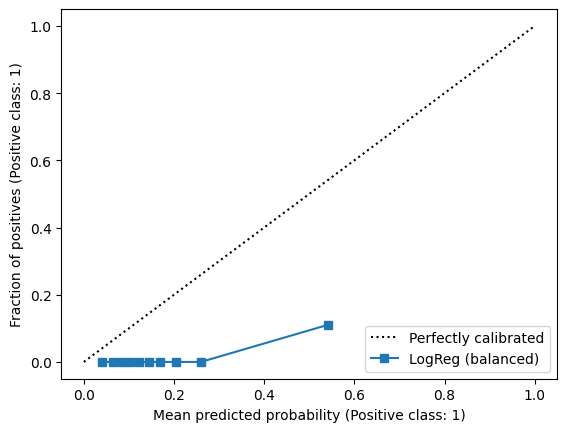

  OK: CalibrationDisplay saved


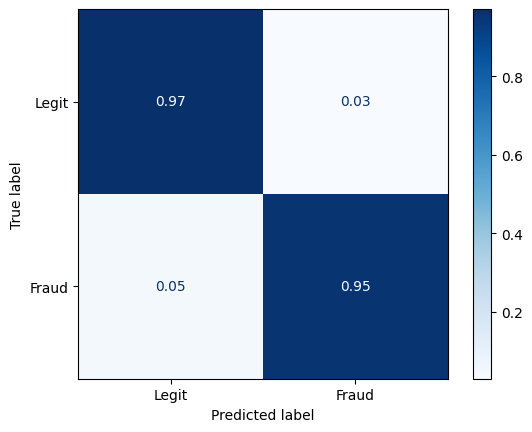

  OK: ConfusionMatrixDisplay saved


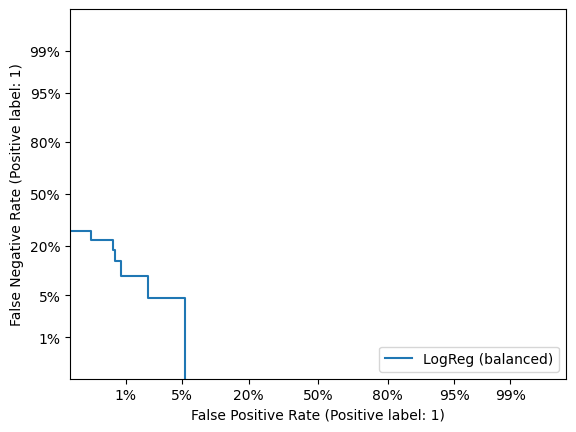

  OK: DetCurveDisplay saved


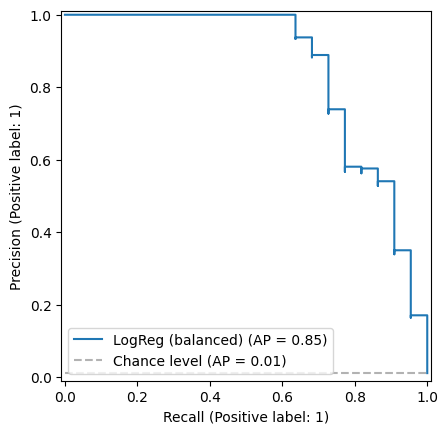

  OK: PrecisionRecallDisplay saved


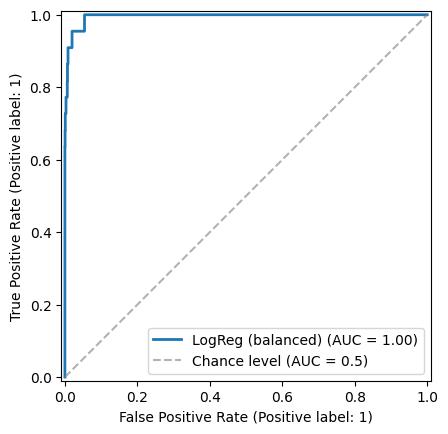

  OK: RocCurveDisplay saved


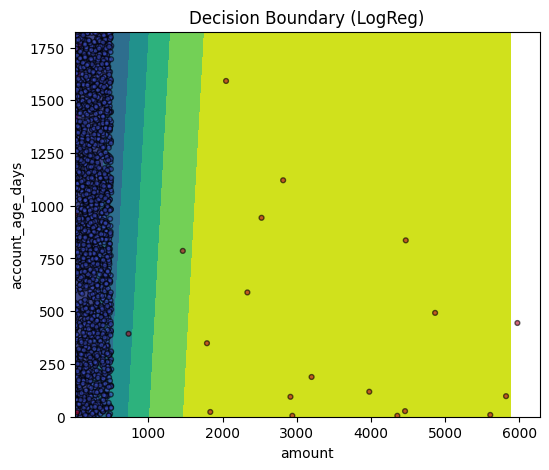

  OK: DecisionBoundaryDisplay saved


/home/rafaelcoelho/Workbench/COELHORealTime/notebooks/.venv/lib/python3.13/site-packages/sklearn/inspection/_partial_dependence.py:721: FutureWarning: The column 1 contains integer data. Partial dependence plots are not supported for integer data: this can lead to implicit rounding with NumPy arrays or even errors with newer pandas versions. Please convert numerical featuresto floating point dtypes ahead of time to avoid problems. This will raise ValueError in scikit-learn 1.9.
  warnings.warn(


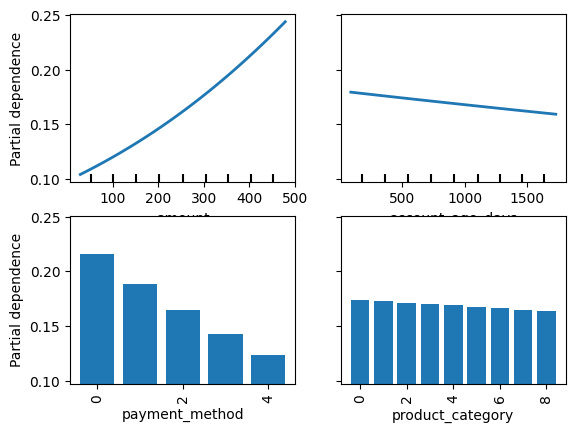

  OK: PartialDependenceDisplay saved


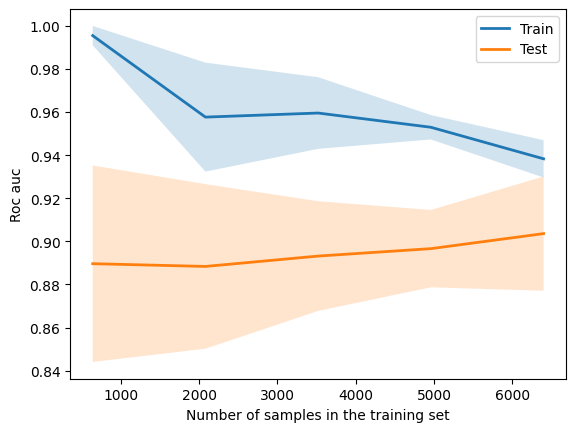

  OK: LearningCurveDisplay saved


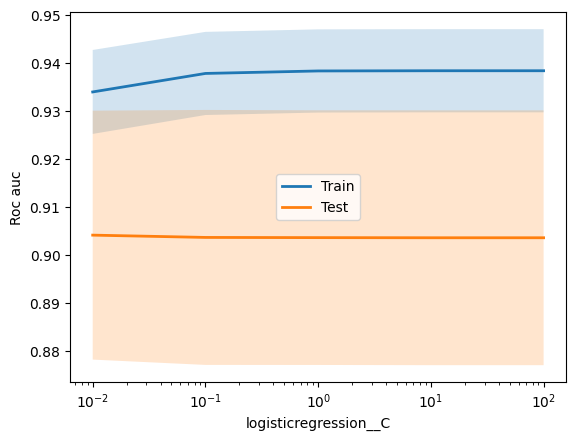

  OK: ValidationCurveDisplay saved

Saved 9 of 9 sklearn visualizations.


In [19]:
def sklearn_classification_visualizers(viz_config: dict):
    results = {}
    errors = []
    total = 0

    def run_display(name, builder):
        nonlocal total
        total += 1
        try:
            display = builder()
            results[name] = save_display(display, f'{name}.png', show=True)
            print(f'  OK: {name} saved')
        except Exception as exc:
            errors.append((name, str(exc)))
            print(f'  FAILED: {name} failed: {exc}')

    print('')
    print('=== Sklearn Visualization Run ===')

    run_display(
        'CalibrationDisplay',
        lambda: CalibrationDisplay.from_estimator(
            base_estimator, X_test, y_test, **viz_config['calibration']
        ),
    )
    run_display(
        'ConfusionMatrixDisplay',
        lambda: ConfusionMatrixDisplay.from_estimator(
            base_estimator, X_test, y_test, **viz_config['confusion_matrix']
        ),
    )
    run_display(
        'DetCurveDisplay',
        lambda: DetCurveDisplay.from_estimator(
            base_estimator, X_test, y_test, **viz_config['det_curve']
        ),
    )
    run_display(
        'PrecisionRecallDisplay',
        lambda: PrecisionRecallDisplay.from_estimator(
            base_estimator, X_test, y_test, **viz_config['precision_recall']
        ),
    )
    run_display(
        'RocCurveDisplay',
        lambda: RocCurveDisplay.from_estimator(
            base_estimator, X_test, y_test, **viz_config['roc_curve']
        ),
    )

    def decision_boundary_builder():
        fig, ax = plt.subplots(figsize=(6, 5))
        display = DecisionBoundaryDisplay.from_estimator(
            boundary_estimator,
            X_train_boundary,
            ax=ax,
            **viz_config['decision_boundary'],
        )
        ax.scatter(
            X_test_boundary[boundary_features[0]],
            X_test_boundary[boundary_features[1]],
            c=y_test,
            cmap='coolwarm',
            alpha=0.6,
            s=12,
            edgecolor='k',
        )
        ax.set_title('Decision Boundary (LogReg)')
        return display

    run_display('DecisionBoundaryDisplay', decision_boundary_builder)
    run_display(
        'PartialDependenceDisplay',
        lambda: PartialDependenceDisplay.from_estimator(
            base_estimator, X_train, **viz_config['partial_dependence']
        ),
    )
    run_display(
        'LearningCurveDisplay',
        lambda: LearningCurveDisplay.from_estimator(
            base_estimator, X_train, y_train, **viz_config['learning_curve']
        ),
    )
    run_display(
        'ValidationCurveDisplay',
        lambda: ValidationCurveDisplay.from_estimator(
            base_estimator, X_train, y_train, **viz_config['validation_curve']
        ),
    )

    print('')
    print(f'Saved {len(results)} of {total} sklearn visualizations.')
    if errors:
        print('Failures:')
        for name, error in errors:
            print(f'  {name}: {error}')
    return results

viz_config = sklearn_classification_viz_config()
results = sklearn_classification_visualizers(viz_config)